<a href="https://colab.research.google.com/github/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# !wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/FullAndFracture.zip
# !unzip /content/FullAndFracture.zip
# !rm FullAndFracture.zip

In [ ]:
!gdown 1AIQPe2G6ZHPwZLmo19-ewbqCNT7TDfYE

Downloading...
From: https://drive.google.com/uc?id=1AIQPe2G6ZHPwZLmo19-ewbqCNT7TDfYE
To: /content/FullAndFracture.npy
100% 466M/466M [00:02<00:00, 167MB/s]


In [ ]:
data = np.load('FullAndFracture.npy')
data.shape  #completo|fracturado, modelos, objeto

(2, 7112, 32, 32, 32)

In [ ]:
X = data[1] #fracturado
Y = data[0] #completo

In [ ]:
def bbvox_points(obj):
  points = []
  for z in range(32):
    for y in range(32):
      for x in range(32):
        if obj[x,y,z] >= 0.5:
          points += [ (x,y,z) ]
  return np.array(points)

def showArr3DC(points, pos=1):
  if len(points) < 1: return
  ax = plt.subplot(1, 3, pos, projection='3d' )
  ax.scatter3D(points[:,0], points[:,1], points[:,2], c='black')

def showArr3DBoolC(obj, pos=1):
  showArr3DC( bbvox_points(obj), pos )

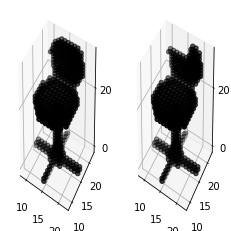

In [ ]:
#@title Visualizar {run: "auto"}
id = 283 #@param {type: 'slider', max:888, min:0, step:1}
showArr3DBoolC(Y[id], 1) #completo
showArr3DBoolC(X[id], 2) #fracturado

# DCGAN3D - Pytorch

In [ ]:
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
torch.manual_seed(0)

In [ ]:
def show_tensor_images(image_tensor, size, pos, num_images=9):
  image_unflat = image_tensor.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=3)
  showArr3DBoolC( image_grid, pos )

In [ ]:
#@title Bloque de Convolución 
class ConvBlock(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""
  # def __init__(self, in_channels, out_channels, mid_channels=None):
  #   super().__init__()
  #   if not mid_channels:
  #     mid_channels = out_channels
  #   self.double_conv = nn.Sequential(
  #     nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
  #     nn.BatchNorm3d(mid_channels),
  #     nn.ReLU(inplace=True),
  #     nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
  #     nn.BatchNorm3d(out_channels),
  #     nn.ReLU(inplace=True)
  #   )
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
      nn.Conv3d(in_channels, out_channels, kernel_size=3, padding='same'),
      nn.BatchNorm3d(out_channels),
      nn.ReLU(inplace=True)
    )
  
  def forward(self, x):
    return self.double_conv(x)

In [ ]:
#@title Discriminador (Encoder)
class Discriminator(nn.Module):
  """Downscaling """
  
  class Down(nn.Module):
    """[Block] Downscaling with AvgPool then double conv"""
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.maxpool_conv = nn.Sequential(
        nn.AvgPool3d(kernel_size = 2),
        ConvBlock(in_channels, out_channels)
      )
    def forward(self, x):
      return self.maxpool_conv(x)

  def __init__(self, trilinear=True):
    super(Discriminator, self).__init__()
    self.inc = ConvBlock(1, 32)      #32^3
    self.down1 = self.Down(32, 64)    #16^3
    self.down2 = self.Down(64, 128)   #8^3
    self.down3 = self.Down(128, 256)  #4^3
    self.factor = 2 if trilinear else 1
    self.down4 = self.Down(256, 512 // self.factor)

  def forward(self, x):
    x = self.inc(x)
    x = self.down1(x)
    x = self.down2(x)
    x = self.down3(x)
    x = self.down4(x)
    return x

In [ ]:
#@title Generador (UNet)
class Generator(Discriminator):
  """Downscaling + Upscaling"""
  
  class Up(nn.Module):
    """[Block] Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, trilinear=True):
      super().__init__()
      # if trilinear, use the normal convolutions to reduce the number of channels
      if trilinear:
        self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv = ConvBlock(in_channels, out_channels) #, in_channels // 2
      else:
        self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
    def forward(self, x1, x2):
      x1 = self.up(x1)
      # input is CHW
      diffY = x2.size()[2] - x1.size()[2]
      diffX = x2.size()[3] - x1.size()[3]
      x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
      x = torch.cat([x2, x1], dim=1)
      return self.conv(x)
    
  def __init__(self, trilinear=True):
    super(Generator, self).__init__(trilinear)
    self.up1 = self.Up(512, 256 // self.factor, trilinear)
    self.up2 = self.Up(256, 128 // self.factor, trilinear)
    self.up3 = self.Up(128, 64 // self.factor, trilinear)
    self.up4 = self.Up(64, 32, trilinear)
    self.outc = ConvBlock(32, 1)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

### Funciones de Pérdida

In [ ]:
def get_gen_loss(gen, disc, criterion, incomplete, num_images, device):
  fake = gen(incomplete)
  disc_fake_pred = disc(fake)
  gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
  return gen_loss

In [ ]:
def get_disc_loss(gen, disc, criterion, incomplete, complete, num_images, device):
  fake = gen(incomplete)
  disc_fake_pred = disc(fake.detach())
  disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
  disc_real_pred = disc(complete)
  disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

# Guardar modelo

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
folder = '/content' #@param {type:'string'}

In [ ]:
def save_model(n):
  torch.save(disc.state_dict(), f'{folder}/disc_{n}.pth')
  torch.save(gen.state_dict(), f'{folder}/gen_{n}.pth')
  print(f'disc_{n}.pth and gen_{n}.pth were saved.')

In [ ]:
def load_model(n, model_type:str = 'gen'):
  """ model_type options: 'gen' | 'disc' """
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # disc = torch.load(f'{folder}/disc_{n}.pth')
  # disc.eval()
  gen = Generator() if model_type=='gen' else Discriminator()
  gen.load_state_dict(torch.load(f'{folder}/{model_type}_{n}.pth', map_location = device))
  return gen.eval()

# Entrenar

**Dataset**

In [ ]:
size = (32,32,32)
# original shape (num_objs, 32, 32, 32)
# shape must be [num_objs, n_channels, depth,height,width]
X = X.reshape( X.shape[0], 1, *size )
Y = Y.reshape( Y.shape[0], 1, *size )

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)

In [ ]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
train_data = TensorDataset(x_train, y_train) #CustomDataset
test_data = TensorDataset(x_test, y_test) #CustomDataset

In [ ]:
n_epochs = 200
save_epoch = 10 #@param {type:'slider', min:1, max:200, step:1}
display_step = 500 #@param {type:'slider', min:500, max:1000, step:1}
batch_size = 96
lr = 0.00001

In [ ]:
criterion = nn.L1Loss() #.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Step 10000: Generator loss: 0.6930094504356386, discriminator loss: 0.6051261096000671
# Epoch 192: Generator loss: 0.04850963485240936, discriminator loss: 0.042283251881599426
# disc_24.pth and gen_24.pth were saved.
new_models = False #@param {type: 'boolean'}
if new_models:
  gen = Generator().to(device)
  disc = Discriminator().to(device)
else:
  last_n_saved = "24" #@param {type:'string'}
  gen = load_model(last_n_saved, 'gen').to(device)
  disc = load_model(last_n_saved, 'disc').to(device)

In [ ]:
# gen_opt = optim.RMSprop(gen.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
gen_opt = optim.Adam(gen.parameters(), lr=lr)
# disc_opt = optim.RMSprop(disc.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
disc_opt = optim.Adam(disc.parameters(), lr=lr)

In [ ]:
def train(last_step=0, last_epoch=0):
  cur_step = last_step
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  gen_loss = False
  error = False

  for epoch in range(last_epoch,n_epochs):
    for incomplete, complete in tqdm(dataloader):
      cur_batch_size = len(complete)
      complete = complete.to(device=device, dtype=torch.float32)
      incomplete = incomplete.to(device=device, dtype=torch.float32)
      #Loss
      disc_opt.zero_grad()
      disc_loss = get_disc_loss(gen, disc, criterion, incomplete, complete, cur_batch_size, device)
      disc_loss.backward(retain_graph=True)
      disc_opt.step()
      gen_opt.zero_grad()
      gen_loss = get_gen_loss(gen, disc, criterion, incomplete, cur_batch_size, device)
      gen_loss.backward()
      gen_opt.step()
      mean_discriminator_loss += disc_loss.item() / display_step
      mean_generator_loss += gen_loss.item() / display_step

      #Display
      if cur_step % display_step == 0 and cur_step > 0:
        print(f"Step {cur_step}: \t Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        fake = gen(incomplete)
        show_tensor_images(incomplete, size, 1)
        show_tensor_images(fake, size, 2)
        show_tensor_images(complete, size, 3)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
      cur_step += 1
    
    print(f"Epoch {epoch} | Step:{cur_step} \t Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}" )
    #Save
    if epoch % save_epoch == 0 and epoch > 0:
      save_model(epoch//save_epoch)

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 0: Generator loss: 0.056855863451957686, discriminator loss: 0.07425705528259274


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1: Generator loss: 0.11429380762577059, discriminator loss: 0.14781335377693172


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2: Generator loss: 0.17209408676624302, discriminator loss: 0.22130834197998037


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3: Generator loss: 0.23006011867523193, discriminator loss: 0.29472483253478987


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4: Generator loss: 0.2882742069959641, discriminator loss: 0.36807696604728696


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5: Generator loss: 0.3467499660253527, discriminator loss: 0.4413843437433242


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6: Generator loss: 0.405506066083908, discriminator loss: 0.5146339383125305


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7: Generator loss: 0.4645518709421157, discriminator loss: 0.5878416531085966


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8: Generator loss: 0.5238739110231401, discriminator loss: 0.6609939700365062
disc_1.pth and gen_1.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Step 500: Generator loss: 0.5616090993881226, discriminator loss: 0.7073982027769085
Epoch 9: Generator loss: 0.021771649003028873, discriminator loss: 0.026707863807678228


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10: Generator loss: 0.08153746056556703, discriminator loss: 0.0997697212696075


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11: Generator loss: 0.14157743537425999, discriminator loss: 0.17278544318676


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12: Generator loss: 0.2018901680707933, discriminator loss: 0.2457574380636215


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13: Generator loss: 0.2624719971418382, discriminator loss: 0.31868640232086193


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14: Generator loss: 0.32332151317596464, discriminator loss: 0.3915739433765412


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15: Generator loss: 0.3844544476270679, discriminator loss: 0.4644193512201309


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16: Generator loss: 0.44585068988800075, discriminator loss: 0.5372268633842469
disc_2.pth and gen_2.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17: Generator loss: 0.5075110325813297, discriminator loss: 0.609994878053665


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18: Generator loss: 0.569465828061104, discriminator loss: 0.6827237496376037


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.5850131745338442, discriminator loss: 0.7008991975784301
Epoch 19: Generator loss: 0.04677559125423431, discriminator loss: 0.054523141264915476


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20: Generator loss: 0.10929304420948033, discriminator loss: 0.1271838561296463


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21: Generator loss: 0.1721427085399628, discriminator loss: 0.19980146420001985


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22: Generator loss: 0.2355408504009248, discriminator loss: 0.27236460208892815


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23: Generator loss: 0.29973864138126416, discriminator loss: 0.34478229200839977


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24: Generator loss: 0.3640521748065953, discriminator loss: 0.41699783229827847
disc_3.pth and gen_3.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25: Generator loss: 0.4286546173095706, discriminator loss: 0.48935414958000145


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26: Generator loss: 0.4936757175922397, discriminator loss: 0.561459952831268


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27: Generator loss: 0.5594716284275055, discriminator loss: 0.6329780900478361


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1500: Generator loss: 0.6173595491647723, discriminator loss: 0.6932763421535493
Epoch 28: Generator loss: 0.00890316128730774, discriminator loss: 0.009487689852714538


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29: Generator loss: 0.07455819201469421, discriminator loss: 0.0798924905061722


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30: Generator loss: 0.14185879874229432, discriminator loss: 0.1493239362239838


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31: Generator loss: 0.2094919567108154, discriminator loss: 0.21822508764266968


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32: Generator loss: 0.2782399888038635, discriminator loss: 0.28594650185108184
disc_4.pth and gen_4.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33: Generator loss: 0.3469452264308931, discriminator loss: 0.3536734837293623


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34: Generator loss: 0.41500698518753065, discriminator loss: 0.421861144542694


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35: Generator loss: 0.4813633621931077, discriminator loss: 0.49003756368160256


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36: Generator loss: 0.5482194747924806, discriminator loss: 0.55792251932621


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37: Generator loss: 0.6155769606828695, discriminator loss: 0.6256860784292221


  0%|          | 0/52 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.6481948752403264, discriminator loss: 0.6581435328721998
Epoch 38: Generator loss: 0.035484841346740716, discriminator loss: 0.03494530022144318


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39: Generator loss: 0.10396296632289888, discriminator loss: 0.10246026360988617


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40: Generator loss: 0.1724835126399993, discriminator loss: 0.16977344846725462
disc_5.pth and gen_5.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41: Generator loss: 0.24209129929542528, discriminator loss: 0.23623603725433345


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42: Generator loss: 0.31226494038105, discriminator loss: 0.30231470501422886


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43: Generator loss: 0.382463881254196, discriminator loss: 0.368364094853401


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44: Generator loss: 0.4526702405214309, discriminator loss: 0.43436248314380643


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45: Generator loss: 0.5231220088005066, discriminator loss: 0.5002065142393111


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46: Generator loss: 0.5935242857933044, discriminator loss: 0.5660303997993468


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47: Generator loss: 0.6636552803516388, discriminator loss: 0.6320359438657757


  0%|          | 0/52 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.6704283721446991, discriminator loss: 0.6383593764305111
Epoch 48: Generator loss: 0.06282368779182435, discriminator loss: 0.05993269050121306
disc_6.pth and gen_6.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49: Generator loss: 0.13188692033290864, discriminator loss: 0.12652916657924648


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50: Generator loss: 0.19967379701137541, discriminator loss: 0.1937774538993835


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 51: Generator loss: 0.26704175579547884, discriminator loss: 0.26126069128513335


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 52: Generator loss: 0.3345638225078583, discriminator loss: 0.32868230342865


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 53: Generator loss: 0.4023544362783434, discriminator loss: 0.3960107831954958


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 54: Generator loss: 0.47037083363533044, discriminator loss: 0.4632831515073779


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 55: Generator loss: 0.5384524259567265, discriminator loss: 0.5305231812000278


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 56: Generator loss: 0.6067141883373269, discriminator loss: 0.5976891188621529
disc_7.pth and gen_7.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.6554070336818707, discriminator loss: 0.6454483242034924
Epoch 57: Generator loss: 0.019759662270545958, discriminator loss: 0.019351221680641174


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 58: Generator loss: 0.08836223530769347, discriminator loss: 0.08639075171947481


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 59: Generator loss: 0.1571287494897842, discriminator loss: 0.1533632292747498


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 60: Generator loss: 0.22605476665496826, discriminator loss: 0.22026957476139078


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 61: Generator loss: 0.2951334570646287, discriminator loss: 0.2871102046966553


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 62: Generator loss: 0.36435850262641917, discriminator loss: 0.35388532948493956


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 63: Generator loss: 0.4337257263660429, discriminator loss: 0.4205951005220413


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 64: Generator loss: 0.5032329444885252, discriminator loss: 0.48723936569690723
disc_8.pth and gen_8.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 65: Generator loss: 0.5728771882057188, discriminator loss: 0.5538189467191699


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 66: Generator loss: 0.6426061763763423, discriminator loss: 0.6203827811479568


  0%|          | 0/52 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.6654389359951015, discriminator loss: 0.6421168966293335
Epoch 67: Generator loss: 0.04706290042400361, discriminator loss: 0.044723880290985105


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 68: Generator loss: 0.1171215643882752, discriminator loss: 0.11111565792560572


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 69: Generator loss: 0.18733751130104068, discriminator loss: 0.17744255721569052


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 70: Generator loss: 0.25770382630825056, discriminator loss: 0.24370526242256152


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 71: Generator loss: 0.32821308922767645, discriminator loss: 0.3099046704769134


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 72: Generator loss: 0.39883257961273194, discriminator loss: 0.3760523160696029
disc_9.pth and gen_9.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 73: Generator loss: 0.4695796055793763, discriminator loss: 0.4421318771839141


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 74: Generator loss: 0.5404498629570013, discriminator loss: 0.5081575107574464


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 75: Generator loss: 0.611421472191811, discriminator loss: 0.5741268997192386


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.6784056183099746, discriminator loss: 0.6362366646528248
Epoch 76: Generator loss: 0.0041042397022247315, discriminator loss: 0.0038010406494140623


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 77: Generator loss: 0.07530172824859623, discriminator loss: 0.06965746891498568


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 78: Generator loss: 0.1466065872907639, discriminator loss: 0.1354605503082276


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 79: Generator loss: 0.21800937938690182, discriminator loss: 0.20121364593505864


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80: Generator loss: 0.28950324571132663, discriminator loss: 0.2669189718961716
disc_10.pth and gen_10.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81: Generator loss: 0.3610623986721039, discriminator loss: 0.33257190537452724


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82: Generator loss: 0.43273137390613553, discriminator loss: 0.3981750507354738


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83: Generator loss: 0.5044902933835984, discriminator loss: 0.46373381900787375


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 84: Generator loss: 0.5763030560016634, discriminator loss: 0.5292512092590335


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 85: Generator loss: 0.648175367712975, discriminator loss: 0.5947218195199968


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.6882866977453238, discriminator loss: 0.6312162748575209
Epoch 86: Generator loss: 0.031819035053253175, discriminator loss: 0.02893612813949585


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 87: Generator loss: 0.10376696491241455, discriminator loss: 0.09433181297779084


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 88: Generator loss: 0.17574049723148344, discriminator loss: 0.15969335138797766
disc_11.pth and gen_11.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 89: Generator loss: 0.24772908091545104, discriminator loss: 0.2250217900276185


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 90: Generator loss: 0.3197089694738388, discriminator loss: 0.29032617318630227


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 91: Generator loss: 0.39170699965953837, discriminator loss: 0.3555930404663086


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 92: Generator loss: 0.4637035624980927, discriminator loss: 0.42082951104640964


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 93: Generator loss: 0.5357241811752319, discriminator loss: 0.4860407859086991


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 94: Generator loss: 0.6077622900009154, discriminator loss: 0.5512208766937257


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 95: Generator loss: 0.6798024755716323, discriminator loss: 0.6163737211227419


  0%|          | 0/52 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.6922708977460861, discriminator loss: 0.6276473793983461
Epoch 96: Generator loss: 0.059573236465454114, discriminator loss: 0.05385234797000885
disc_12.pth and gen_12.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 97: Generator loss: 0.13161207687854767, discriminator loss: 0.11895421564579005


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 98: Generator loss: 0.20364681327342982, discriminator loss: 0.1840312107801437


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 99: Generator loss: 0.2756899658441543, discriminator loss: 0.2490785654783249


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 100: Generator loss: 0.34774195027351357, discriminator loss: 0.314096880674362


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 101: Generator loss: 0.419797430515289, discriminator loss: 0.3790879772901532


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 102: Generator loss: 0.49185251939296687, discriminator loss: 0.4440536943674085


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 103: Generator loss: 0.5639057029485699, discriminator loss: 0.5089944396018979


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 104: Generator loss: 0.6359645490646356, discriminator loss: 0.5739080263376235
disc_13.pth and gen_13.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.6927807389497749, discriminator loss: 0.6250716695785519
Epoch 105: Generator loss: 0.01524352967739105, discriminator loss: 0.013724093675613402


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 106: Generator loss: 0.08730536675453188, discriminator loss: 0.07858542287349699


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 107: Generator loss: 0.1593679057359696, discriminator loss: 0.1434210410118103


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 108: Generator loss: 0.23142732989788048, discriminator loss: 0.20823277246952066


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 109: Generator loss: 0.30348804819583886, discriminator loss: 0.2730186971426011


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 110: Generator loss: 0.3755471773147583, discriminator loss: 0.33778007888793954


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 111: Generator loss: 0.4476081000566483, discriminator loss: 0.4025148613452914


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 112: Generator loss: 0.5196695069074629, discriminator loss: 0.46722419452667246
disc_14.pth and gen_14.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 113: Generator loss: 0.5917332968711851, discriminator loss: 0.531907232403755


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 114: Generator loss: 0.6637888666391369, discriminator loss: 0.5965681612491608


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.6928894528150555, discriminator loss: 0.6226742457151413
Epoch 115: Generator loss: 0.042958116412162774, discriminator loss: 0.03852996194362641


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 116: Generator loss: 0.1150197575092316, discriminator loss: 0.10313978493213659


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 117: Generator loss: 0.18708353435993197, discriminator loss: 0.16772387576103218


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 118: Generator loss: 0.25914889681339265, discriminator loss: 0.2322824004888535


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 119: Generator loss: 0.3312139031887056, discriminator loss: 0.29681611609458924


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 120: Generator loss: 0.4032782349586489, discriminator loss: 0.36132562172412863
disc_15.pth and gen_15.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 121: Generator loss: 0.47534392607212095, discriminator loss: 0.42580966520309427


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 122: Generator loss: 0.5474096887111666, discriminator loss: 0.4902686982154843


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 123: Generator loss: 0.6194737120866777, discriminator loss: 0.5547042126655575


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 124: Generator loss: 0.6915380072593688, discriminator loss: 0.6191150493621823


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.6929238643646238, discriminator loss: 0.6203534668684003
Epoch 125: Generator loss: 0.07068032777309417, discriminator loss: 0.06314644849300387


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 126: Generator loss: 0.14274372708797453, discriminator loss: 0.12750847518444058


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 127: Generator loss: 0.21480800163745886, discriminator loss: 0.19184578669071192


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 128: Generator loss: 0.28687484514713296, discriminator loss: 0.2561574546098709
disc_16.pth and gen_16.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 129: Generator loss: 0.3589420094490054, discriminator loss: 0.32044441401958457


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 130: Generator loss: 0.4310097616910934, discriminator loss: 0.38470677459239944


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 131: Generator loss: 0.5030766011476516, discriminator loss: 0.44894532966613754


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 132: Generator loss: 0.5751438874006269, discriminator loss: 0.5131593794822691


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 133: Generator loss: 0.6472125655412673, discriminator loss: 0.5773482691049572


  0%|          | 0/52 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.6929476333856578, discriminator loss: 0.618071473717689
Epoch 134: Generator loss: 0.026332024455070494, discriminator loss: 0.023442428469657897


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 135: Generator loss: 0.0984005960226059, discriminator loss: 0.08758328199386596


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 136: Generator loss: 0.17047113001346587, discriminator loss: 0.15169904839992518
disc_17.pth and gen_17.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 137: Generator loss: 0.24254080379009257, discriminator loss: 0.21579091584682453


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 138: Generator loss: 0.3146118612289432, discriminator loss: 0.2798579146862028


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 139: Generator loss: 0.3866832749843601, discriminator loss: 0.3439002757072445


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 140: Generator loss: 0.45875080204010055, discriminator loss: 0.40792072963714576


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 141: Generator loss: 0.530817235708237, discriminator loss: 0.47191780436038944


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 142: Generator loss: 0.6028835139274604, discriminator loss: 0.5358911387920375


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 143: Generator loss: 0.6749507020711908, discriminator loss: 0.5998403706550595


  0%|          | 0/52 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.6929676011800774, discriminator loss: 0.6158239525556561
Epoch 144: Generator loss: 0.05405065381526947, discriminator loss: 0.04794191610813141
disc_18.pth and gen_18.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 145: Generator loss: 0.12612091743946077, discriminator loss: 0.11184233343601223


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 146: Generator loss: 0.19818979597091685, discriminator loss: 0.17571965324878683


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 147: Generator loss: 0.2702624212503434, discriminator loss: 0.23957158148288704


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 148: Generator loss: 0.3423346847295763, discriminator loss: 0.30339966762065873


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 149: Generator loss: 0.41440653955936435, discriminator loss: 0.3672043162584303


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 150: Generator loss: 0.4864792770147323, discriminator loss: 0.4309848526716231


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 151: Generator loss: 0.5585512503385544, discriminator loss: 0.49474202728271477


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 152: Generator loss: 0.6306239175796504, discriminator loss: 0.5584753190279006
disc_19.pth and gen_19.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.6929940756559368, discriminator loss: 0.6136100823879239
Epoch 153: Generator loss: 0.009701885223388673, discriminator loss: 0.008575041651725769


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 154: Generator loss: 0.08177211630344391, discriminator loss: 0.0722623872756958


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 155: Generator loss: 0.15384349930286406, discriminator loss: 0.13592583608627318


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 156: Generator loss: 0.2259144365787506, discriminator loss: 0.19956616830825802


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 157: Generator loss: 0.29798644387722023, discriminator loss: 0.2631826273202895


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 158: Generator loss: 0.3700586642026903, discriminator loss: 0.3267757430076597


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 159: Generator loss: 0.44213138794898993, discriminator loss: 0.3903452962636945


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 160: Generator loss: 0.5142034760713579, discriminator loss: 0.4538918989896772
disc_20.pth and gen_20.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 161: Generator loss: 0.5862761111259462, discriminator loss: 0.5174150123596187


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 162: Generator loss: 0.6583498971462249, discriminator loss: 0.5809143294095989


  0%|          | 0/52 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.6930008671283722, discriminator loss: 0.6114345065355296
Epoch 163: Generator loss: 0.03742296969890594, discriminator loss: 0.03295582771301269


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 164: Generator loss: 0.1094931118488312, discriminator loss: 0.09641067767143247


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 165: Generator loss: 0.18156378328800205, discriminator loss: 0.1598423308134079


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 166: Generator loss: 0.25363493609428395, discriminator loss: 0.22325086843967445


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 167: Generator loss: 0.3257069188356398, discriminator loss: 0.2866360888481141


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 168: Generator loss: 0.3977794207334515, discriminator loss: 0.34999838244915
disc_21.pth and gen_21.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 169: Generator loss: 0.4698523824214934, discriminator loss: 0.4133375315666199


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 170: Generator loss: 0.5419248893260956, discriminator loss: 0.4766541341543196


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 171: Generator loss: 0.6139995795488361, discriminator loss: 0.5399466902017589


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 172: Generator loss: 0.6860742216110228, discriminator loss: 0.6032165304422374


  0%|          | 0/52 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.6930044747591017, discriminator loss: 0.6092989658117289
Epoch 173: Generator loss: 0.06514256715774536, discriminator loss: 0.05716538524627686


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 174: Generator loss: 0.13721507728099833, discriminator loss: 0.12039065337181086


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 175: Generator loss: 0.20928889274597182, discriminator loss: 0.1835924679040909


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 176: Generator loss: 0.28136286699771895, discriminator loss: 0.2467714357376099
disc_22.pth and gen_22.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 177: Generator loss: 0.353437276363373, discriminator loss: 0.3099275815486907


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 178: Generator loss: 0.42551114034652754, discriminator loss: 0.37306143784523016


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 179: Generator loss: 0.49758514237403917, discriminator loss: 0.4361725374460222


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 180: Generator loss: 0.5696593067646034, discriminator loss: 0.4992611186504364


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 181: Generator loss: 0.6417318564653403, discriminator loss: 0.5623280469179154


  0%|          | 0/52 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.6930146301984795, discriminator loss: 0.6071888989210129
Epoch 182: Generator loss: 0.020790536284446718, discriminator loss: 0.018183502554893496


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 183: Generator loss: 0.09286401581764223, discriminator loss: 0.08120540034770966


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 184: Generator loss: 0.1649383038282394, discriminator loss: 0.14420460009574887
disc_23.pth and gen_23.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 185: Generator loss: 0.2370119124650956, discriminator loss: 0.20718190920352936


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 186: Generator loss: 0.30908497929573064, discriminator loss: 0.2701373074054718


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 187: Generator loss: 0.3811574100255968, discriminator loss: 0.3330709091424941


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 188: Generator loss: 0.45323016130924243, discriminator loss: 0.39598225939273823


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 189: Generator loss: 0.5253021512031554, discriminator loss: 0.4588720225095746


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 190: Generator loss: 0.5973748127222059, discriminator loss: 0.5217395002841947


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 191: Generator loss: 0.6694476355314258, discriminator loss: 0.5845849752426148


  0%|          | 0/52 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.6930094504356386, discriminator loss: 0.6051261096000671
Epoch 192: Generator loss: 0.04850963485240936, discriminator loss: 0.042283251881599426
disc_24.pth and gen_24.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 193: Generator loss: 0.12058114874362943, discriminator loss: 0.10508570921421057


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 194: Generator loss: 0.19265290999412535, discriminator loss: 0.16786635875701908


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 195: Generator loss: 0.2647252604961395, discriminator loss: 0.23062499344348905


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 196: Generator loss: 0.3367985051870347, discriminator loss: 0.2933615503311156


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 197: Generator loss: 0.40887068247795116, discriminator loss: 0.356076825261116


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 198: Generator loss: 0.4809428569078447, discriminator loss: 0.41877036619186403


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 199: Generator loss: 0.5530161557197573, discriminator loss: 0.4814417147636412


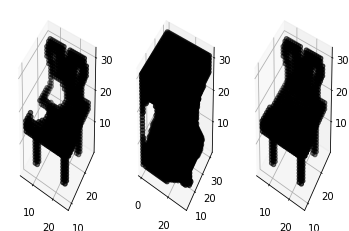

In [ ]:
train(last_step=0, last_epoch=0)

In [ ]:
save_model('last')

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 0 | Step:52 	 Generator loss: 0.1039999971389771, Discriminator loss: 0.022912857562303542


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 | Step:104 	 Generator loss: 0.2079999721050263, Discriminator loss: 0.04577816665172577


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 | Step:156 	 Generator loss: 0.31199991309642794, Discriminator loss: 0.06861022534966471


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 | Step:208 	 Generator loss: 0.41599983489513415, Discriminator loss: 0.0914117480516434


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 | Step:260 	 Generator loss: 0.5199997515678408, Discriminator loss: 0.11418583214282996


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 | Step:312 	 Generator loss: 0.6239996937513351, Discriminator loss: 0.1369408567845823


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 | Step:364 	 Generator loss: 0.7279996201992032, Discriminator loss: 0.15968672734498995


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 | Step:416 	 Generator loss: 0.8319995472431179, Discriminator loss: 0.18241302213072796


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 | Step:468 	 Generator loss: 0.9359994778633113, Discriminator loss: 0.20512873953580876


  0%|          | 0/52 [00:00<?, ?it/s]

Step 500: 	 Generator loss: 1.0019994384050361, Discriminator loss: 0.21954058700799953
Epoch 9 | Step:520 	 Generator loss: 0.03799998295307161, Discriminator loss: 0.008299427926540374


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 | Step:572 	 Generator loss: 0.1419999233484269, Discriminator loss: 0.030999982267618176
disc_1.pth and gen_1.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 | Step:624 	 Generator loss: 0.24599983239173903, Discriminator loss: 0.05370066741108895


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 | Step:676 	 Generator loss: 0.3499997261762621, Discriminator loss: 0.07638663440942765


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 | Step:728 	 Generator loss: 0.440164142906666, Discriminator loss: 0.10626129150390624


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 | Step:780 	 Generator loss: 0.5111999585628514, Discriminator loss: 0.14980786389112474


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 | Step:832 	 Generator loss: 0.6138621256351479, Discriminator loss: 0.17976181972026822


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 | Step:884 	 Generator loss: 0.7177861038446437, Discriminator loss: 0.2077225021719933


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 | Step:936 	 Generator loss: 0.8217300657033929, Discriminator loss: 0.23481023716926588


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 | Step:988 	 Generator loss: 0.9256879395246514, Discriminator loss: 0.2610193873047831


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1000: 	 Generator loss: 0.9516769323349006, Discriminator loss: 0.26742642411589646
Epoch 19 | Step:1040 	 Generator loss: 0.07796864140033721, Discriminator loss: 0.018876341730356218


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 | Step:1092 	 Generator loss: 0.18193605947494507, Discriminator loss: 0.04319723364710808
disc_2.pth and gen_2.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

RuntimeError: ignored

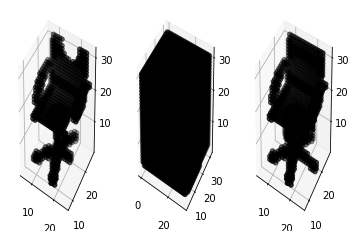

In [ ]:
train(last_step=0, last_epoch=0)

In [ ]:
# limpiar memoria
# with torch.no_grad():
#   torch.cuda.empty_cache()

# Testing

In [ ]:
!wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/broken_chair.npy?raw=true -O broken_chair.npy

--2022-11-20 09:12:05--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/broken_chair.npy?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/raw/main/data/broken_chair.npy [following]
--2022-11-20 09:12:06--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/raw/main/data/broken_chair.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Coralain10/ML_Archaeological-Objects-Reconstruction/main/data/broken_chair.npy [following]
--2022-11-20 09:12:06--  https://raw.githubusercontent.com/Coralain10/ML_Archaeological-Objects-Reconstruction/main/data/broken_chair.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.1

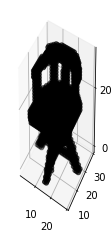

In [ ]:
filename = 'broken_chair.npy' #@param {type:'string'}
array = np.load(filename)
showArr3DBoolC(array)

In [ ]:
array_t = torch.from_numpy( array.reshape(1,1, 32,32,32) ).float()
array_t.shape

torch.Size([1, 1, 32, 32, 32])

In [ ]:
generated = gen(array_t)

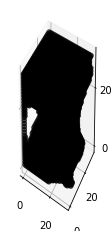

In [ ]:
show_tensor_images(generated, (32,32,32), 1, num_images=1)